In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as font_manager
plt.rcParams["font.family"] = "serif"
plt.style.use('classic')
font = font_manager.FontProperties(family='serif', size=16)
from scipy.stats import norm, expon
import os, json, glob, random, h5py,time
from scipy.stats import norm, expon, chi2

# Useful definitions

In [7]:
folders = {
    'background':'./data/background_11dim.npy',
    'bbh': './data/bbh_11dim.npy',
    'sghf': './data/sghf_11dim.npy',
    'sglf': './data/sglf_11dim.npy'
}
physics_labels = list(folders.keys())
colors_list = ['black','#bdc9e1','#67a9cf','#1c9099','#016c59', 'dodgerblue']

colors = {physics_labels[i]: colors_list[i] for i in range(len(physics_labels))}

labels_vars=["H background-like", "L background-like", "H BBH-like",
        "L BBH-like", "H Glitch-like", "L Glitch-like", "H SG lf - like",
        "L SG lf - like", "H SG hf - like", "L SG hf - like",
        "Frequency correlation"]

def plot_pvalues(pval, signal, ND, NR, lam, sigma, saveplot=False, savepath=''):
    fig = plt.figure(figsize=(14, 6))
    fig.patch.set_facecolor('white')
    plt.plot(pval)
    plt.yscale('log')
    plt.xlabel('time window', fontname='serif', fontsize=18)
    plt.ylabel(r'$p$-value', fontname='serif', fontsize=18)
    alpha_2=0.02275013194817921
    plt.hlines(xmin=0, xmax=len(pval), y=alpha_2, color='black')
    plt.text(x=len(pval)*1.01, y=alpha_2, s='Z=2', fontname='serif', fontsize=16)
    alpha_3=0.0013498980316300933
    plt.hlines(xmin=0, xmax=len(pval), y=alpha_3, color='black')
    plt.text(x=len(pval)*1.01, y=alpha_3, s='Z=3', fontname='serif', fontsize=16)
    plt.grid()
    plt.ylim(0.001, 1)
    plt.title('%s signal, window size: %s, ref size: %s, lam-FLK: %s sigma-FLK: %s'%(signal, ND, NR, lam, sigma), fontname='serif', fontsize=18)
    if saveplot and savepath != '':
        plt.savefig(savepath)
    plt.show()
    print('P(Z-score > 2)=', np.sum(pval<alpha_2)/len(pval))
    return

def Z_score_chi2(t,df):
    sf = chi2.sf(t, df)
    Z  = -norm.ppf(sf)
    return Z

def Z_score_norm(t,mu, std):
    sf = norm.sf(t, mu, std)
    Z  = -norm.ppf(sf)
    return Z

def plot_1distribution(t, df=-1, xmin=0, xmax=300, nbins=10, save=False, ymax=None, Zscore=False, output_path='', save_name='', label=''):
    '''
    Plot the histogram of a test statistics sample (t) and the target chi2 distribution (df must be specified!). 
    The median and the error on the median are calculated in order to calculate the median Z-score and its error.
    '''
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    fig  = plt.figure(figsize=(12, 9))
    fig.patch.set_facecolor('white')
    # plot distribution histogram
    bins      = np.linspace(xmin, xmax, nbins+1)
    Z_obs     = norm.ppf(chi2.cdf(np.median(t), df))
    t_obs_err = 1.2533*np.std(t)*1./np.sqrt(t.shape[0])
    Z_obs_p   = norm.ppf(chi2.cdf(np.median(t)+t_obs_err, df))
    Z_obs_m   = norm.ppf(chi2.cdf(np.median(t)-t_obs_err, df))
    label  = 'sample %s\nsize: %i \nmedian: %s, std: %s\n'%(label, t.shape[0], str(np.around(np.median(t), 2)),str(np.around(np.std(t), 2)))
    if Zscore:
        label += 'Z = %s (+%s/-%s)'%(str(np.around(Z_obs, 2)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2)))
    binswidth = (xmax-xmin)*1./nbins
    h = plt.hist(t, weights=np.ones_like(t)*1./(t.shape[0]*binswidth), color='lightblue', ec='#2c7fb8',
                 bins=bins, label=label)
    err = np.sqrt(h[0]/(t.shape[0]*binswidth))
    x   = 0.5*(bins[1:]+bins[:-1])
    plt.errorbar(x, h[0], yerr = err, color='#2c7fb8', marker='o', ls='')
    if df>0:
        # plot reference chi2
        x  = np.linspace(chi2.ppf(0.0001, df), chi2.ppf(0.9999, df), 100)
        plt.plot(x, chi2.pdf(x, df),'midnightblue', lw=5, alpha=0.8, label=r'$\chi^2_{%i}$'%(df))
    font = font_manager.FontProperties(family='serif', size=14) 
    plt.legend(prop=font, frameon=False)
    plt.xlabel('t', fontsize=18, fontname="serif")
    plt.ylabel('Probability', fontsize=18, fontname="serif")
    plt.yticks(fontsize=16, fontname="serif")
    plt.xticks(fontsize=16, fontname="serif")
    if ymax !=None:
        plt.ylim(0., ymax)
    if save:
        if output_path=='':
            print('argument output_path is not defined. The figure will not be saved.')
        else:
            plt.savefig(output_path+ save_name+'_distribution.pdf')
            print('saved at %s'%(output_path+ save_name+'_distribution.pdf'))
    plt.show()
    plt.close(fig)
    return

def plot_2distribution(t1, t2, df=-1, mu=-1, std=-1, xmin=0, xmax=300, ymax=None, xlog=False, nbins=10, save=False, output_path='', label1='1', label2='2', save_name='', print_Zscore=True):
    '''
    Plot the histogram of a test statistics sample (t) and the target chi2 distribution (df must be specified!).
    The median and the error on the median are calculated in order to calculate the median Z-score and its error.
    '''
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    fig  = plt.figure(figsize=(12, 9))
    fig.patch.set_facecolor('white')
    # plot distribution histogram
    bins      = np.linspace(xmin, xmax, nbins+1)
    binswidth = (xmax-xmin)*1./nbins
    # t1
    if df>=0:
        Z_obs     = Z_score_chi2(np.median(t1), df)
        t_obs_err = 1.2533*np.std(t1)*1./np.sqrt(t1.shape[0])
        Z_obs_p   = Z_score_chi2(np.median(t1)+t_obs_err, df)
        Z_obs_m   = Z_score_chi2(np.median(t1)-t_obs_err, df)
    elif mu>=0 and std>=0:
        Z_obs     = Z_score_norm(np.median(t1), mu, std)
        t_obs_err = 1.2533*np.std(t1)*1./np.sqrt(t1.shape[0])
        Z_obs_p   = Z_score_norm(np.median(t1)+t_obs_err, mu, std)
        Z_obs_m   = Z_score_norm(np.median(t1)-t_obs_err, mu, std)
    else:
        Z_obs     = 0
        t_obs_err = 0
        Z_obs_p   = 0
        Z_obs_m   = 0
    label  = '%s \nsize: %i\nmedian: %s, std: %s\n'%(label1, t1.shape[0], str(np.around(np.median(t1), 2)),str(np.around(np.std(t1), 2)))
    if print_Zscore:
        label += 'asymptotic Z = %s (+%s/-%s)'%(str(np.around(Z_obs, 2)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2)))
    
    h = plt.hist(t1, weights=np.ones_like(t1)*1./(t1.shape[0]*binswidth), color='lightblue', ec='#2c7fb8',
                 bins=bins, label=label)
    err = np.sqrt(h[0]/(t1.shape[0]*binswidth))
    x   = 0.5*(bins[1:]+bins[:-1])
    plt.errorbar(x, h[0], yerr = err, color='#2c7fb8', marker='o', ls='')
    max1 = np.max(h[0])
    # t2
    if df>=0:
        Z_obs     = Z_score_chi2(np.median(t2), df)
        t_obs_err = 1.2533*np.std(t2)*1./np.sqrt(t2.shape[0])
        Z_obs_p   = Z_score_chi2(np.median(t2)+t_obs_err, df)
        Z_obs_m   = Z_score_chi2(np.median(t2)-t_obs_err, df)
    elif mu>=0 and std>=0:
        Z_obs     = Z_score_norm(np.median(t2), mu, std)
        t_obs_err = 1.2533*np.std(t2)*1./np.sqrt(t2.shape[0])
        Z_obs_p   = Z_score_norm(np.median(t2)+t_obs_err, mu, std)
        Z_obs_m   = Z_score_norm(np.median(t2)-t_obs_err, mu, std)
    else:
        Z_obs     = 0
        t_obs_err = 0
        Z_obs_p   = 0
        Z_obs_m   = 0
    
    t_empirical = np.sum(1.*(t1>np.mean(t2)))*1./t1.shape[0]
    empirical_lim = '='
    if t_empirical==0:
        empirical_lim='>'
        t_empirical = 1./t1.shape[0]
    t_empirical_err = t_empirical*np.sqrt(1./np.sum(1.*(t1>np.mean(t2))+1./t1.shape[0]))
    Z_empirical = norm.ppf(1-t_empirical)
    Z_empirical_m = norm.ppf(1-(t_empirical+t_empirical_err))
    Z_empirical_p = norm.ppf(1-(t_empirical-t_empirical_err))
                                          
    label  = '%s \nsize: %i\nmedian: %s, std: %s\n'%(label2, t2.shape[0], str(np.around(np.median(t2), 2)),str(np.around(np.std(t2), 2)))
    if print_Zscore:
        label += 'asymptotic Z = %s (+%s/-%s) \n'%(str(np.around(Z_obs, 2)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2)))
        label += 'empirical Z %s %s (+%s/-%s)'%(empirical_lim, str(np.around(Z_empirical, 2)), str(np.around(Z_empirical_p-Z_empirical, 2)), str(np.around(Z_empirical-Z_empirical_m, 2)))
    h = plt.hist(t2, weights=np.ones_like(t2)*1./(t2.shape[0]*binswidth), color='#8dd3c7', ec='seagreen',
                 bins=bins, label=label)
    err = np.sqrt(h[0]/(t2.shape[0]*binswidth))
    x   = 0.5*(bins[1:]+bins[:-1])
    plt.errorbar(x, h[0], yerr = err, color='seagreen', marker='o', ls='')
    max2 = np.max(h[0])
    if df>=0:
        # plot reference chi2
        x  = np.linspace(chi2.ppf(0.0001, df), chi2.ppf(0.9999, df), 100)
        plt.plot(x, chi2.pdf(x, df),'midnightblue', lw=5, alpha=0.8, label=r'$\chi^2_{%i}$'%(df))
    elif mu>=0 and std>=0:
        # plot reference chi2
        x  = np.linspace(norm.ppf(0.0001, mu, std), norm.ppf(0.9999, mu, std), 100)
        plt.plot(x, norm.pdf(x, mu, std),'midnightblue', lw=5, alpha=0.8, label='N(%s, %s)'%(str(mu), str(std)))
    font = font_manager.FontProperties(family='serif', size=20) #weight='bold', style='normal', 
    plt.legend(ncol=1, loc='upper right', prop=font, frameon=False)
    plt.xlabel('$t$', fontsize=32, fontname="serif")
    plt.ylabel('Probability', fontsize=32, fontname="serif")
    plt.ylim(0., 1.2*np.maximum(max1, max2))#np.max(chi2.pdf(x, df))*1.3)
    if ymax !=None:
        plt.ylim(0., ymax)
    plt.yticks(fontsize=22, fontname="serif")
    plt.xticks(fontsize=22, fontname="serif")
    if xlog:
        plt.xscale('log')
    if save:
        if output_path=='':
            print('argument output_path is not defined. The figure will not be saved.')
        else:
            plt.savefig(output_path+ save_name+'_2distribution.png')
    plt.show()
    plt.close()
    return [Z_obs, Z_obs_p, Z_obs_m], [Z_empirical, Z_empirical_p, Z_empirical_m]

def Plot_Percentiles_ref(tvalues_check, dof, patience=1, title='', wc=None, ymax=300, ymin=0, save=False, output_path=''):
    '''
    The funcion creates the plot of the evolution in the epochs of the [2.5%, 25%, 50%, 75%, 97.5%] quantiles of the toy sample distribution.
    The percentile lines for the target chi2 distribution (dof required!) are shown as a reference.
    patience: interval between two check points (epochs).
    tvalues_check: array of t=-2*loss, shape = (N_toys, N_check_points)
    '''
    colors = [
    'seagreen',
    'mediumseagreen',
    'lightseagreen',
    '#2c7fb8',
    'midnightblue',
    ]
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    epochs_check = []
    nr_check_points = tvalues_check.shape[1]
    for i in range(nr_check_points):
        epoch_check = patience*(i+1)
        epochs_check.append(epoch_check)
    
    fig=plt.figure(figsize=(12, 9))
    fig.patch.set_facecolor('white')
    quantiles=[2.5, 25, 50, 75, 97.5]
    percentiles=np.array([])
    plt.xlabel('Training Epochs', fontsize=16, fontname="serif")
    plt.ylabel('t', fontsize=16, fontname="serif")
    plt.ylim(ymin, ymax)
    if wc != None:
        plt.title('Weight Clipping = '+wc, fontsize=16,  fontname="serif")
    for i in range(tvalues_check.shape[1]):
        percentiles_i = np.percentile(tvalues_check[:, i], quantiles)
        percentiles_i = np.expand_dims(percentiles_i, axis=1)
        if not i:
            percentiles = percentiles_i.T
        else:
            percentiles = np.concatenate((percentiles, percentiles_i.T))
    legend=[]
    for j in range(percentiles.shape[1]):
        plt.plot(epochs_check, percentiles[:, j], marker='.', linewidth=3, color=colors[j])
        legend.append(str(quantiles[j])+' % quantile')
    for j in range(percentiles.shape[1]):
        plt.plot(epochs_check, chi2.ppf(quantiles[j]/100., df=dof, loc=0, scale=1)*np.ones_like(epochs_check),
                color=colors[j], ls='--', linewidth=1)
        if j==0:
            legend.append("Target "+r"$\chi^2(dof=$"+str(dof)+")")
    font = font_manager.FontProperties(family='serif', size=16)         
    plt.legend(legend, prop=font)
    plt.yticks(fontsize=16, fontname="serif")
    plt.xticks(fontsize=16, fontname="serif")
    if save:
        if output_path=='':
            print('argument output_path is not defined. The figure will not be saved.')
        else:
            fig.savefig(output_path+title+'_PlotPercentiles.pdf')
    plt.show()
    plt.close(fig)
    return

# Load data

In [3]:
data = {}
for folder in folders:
    data[folder] = np.load(folders[folder]).reshape((-1, 11))

# Plot input data

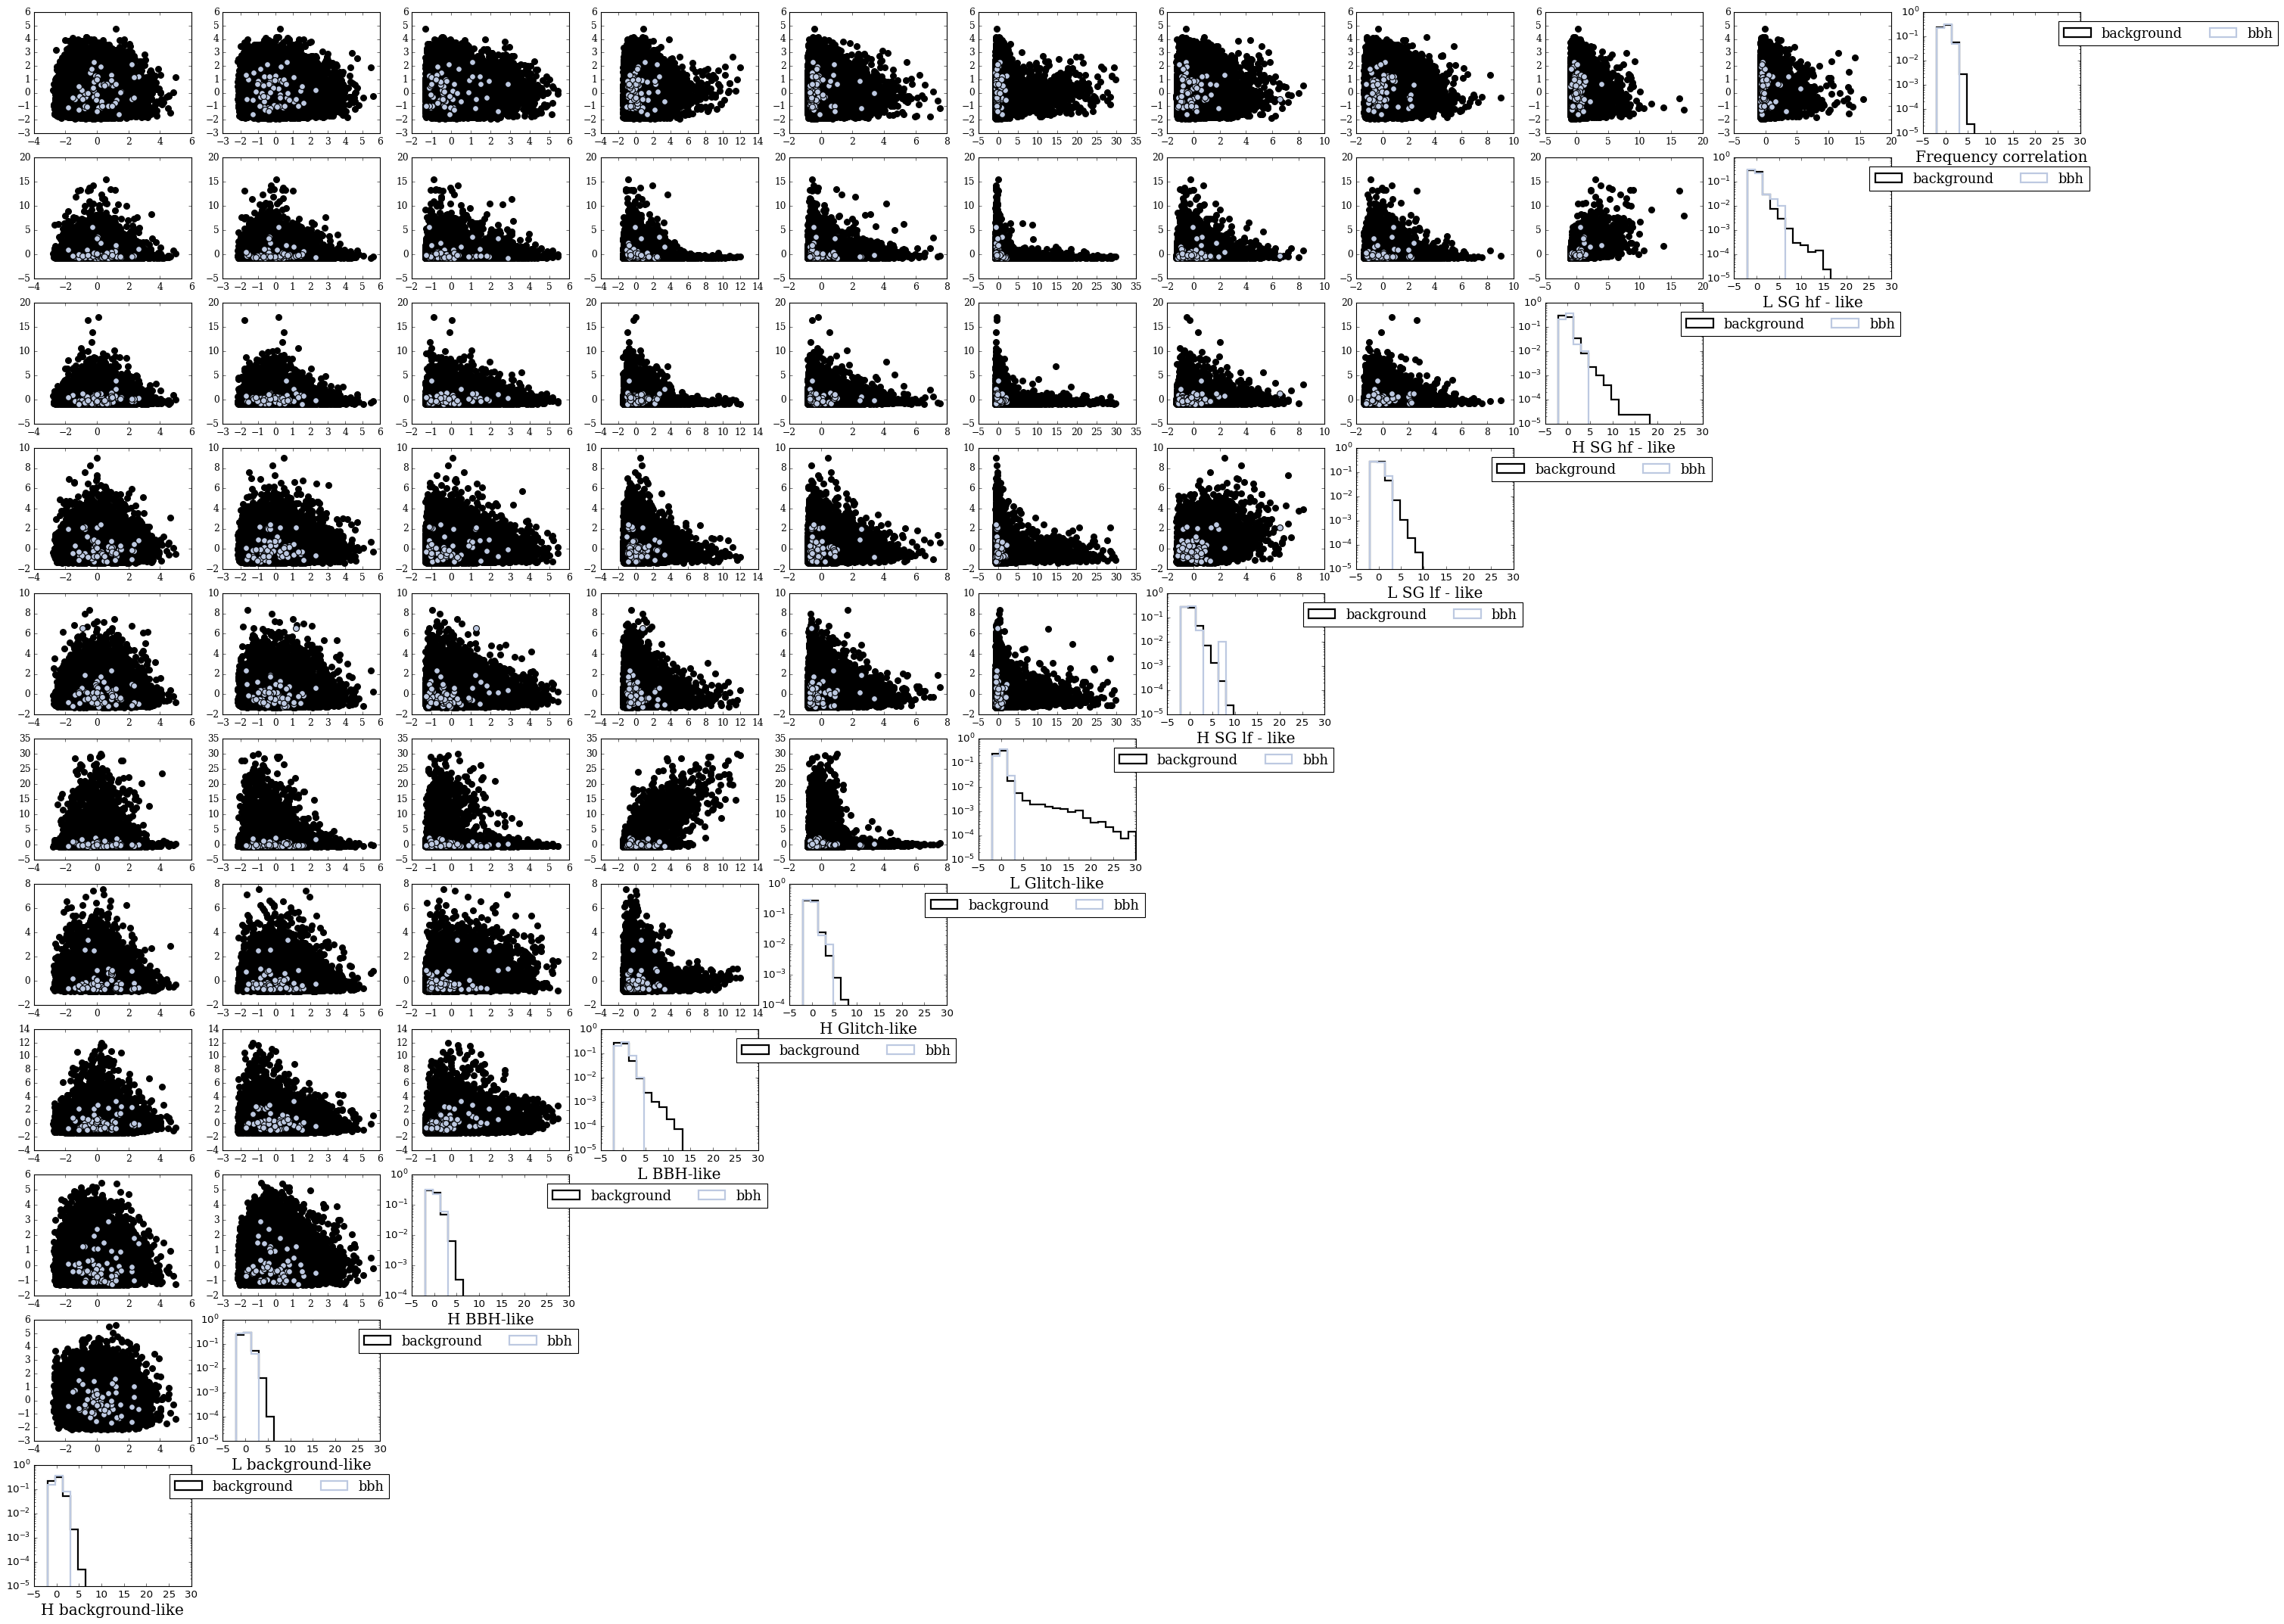

In [5]:
signals = ['bbh']
fig  = plt.figure(figsize=(26, 20))
fig.patch.set_facecolor('white')
NR = 24200
ND = 60
x = data['background'][:NR]
#y = data[signal][:N]
for i in range(x.shape[1]):
    x_i = x[:, i]
    for j in range(x.shape[1]):
        if j>i:
            x_j = x[:, j]
            ax= fig.add_axes([0.05+i*0.12, 0.05+j*0.12, 0.10, 0.10])
            plt.yticks(fontsize=11, fontname='serif')
            plt.xticks(fontsize=11, fontname='serif')
            plt.scatter(x_i, x_j, c=colors['background'], s=50)
            for signal in signals:
                y = data[signal][:ND]
                plt.scatter(y[:, i], y[:, j], c=colors[signal], s=50)
        elif i==j:
            ax= fig.add_axes([0.05+i*0.12, 0.05+j*0.12, 0.1, 0.1])
            bins = np.linspace(-2, 30, 20)#(np.min(x_i), np.max(x_i), 20)
            plt.xlabel(labels_vars[i], fontsize=18, fontname='serif')
            plt.hist(x_i, density=True,
                    histtype='step', lw=2, label='background',
                         color=colors['background'],bins=bins)
            for signal in signals:
                y = data[signal][:ND]
                plt.hist(y[:, i], density=True,
                         histtype='step', lw=2,
                         color=colors[signal],bins=bins, label='%s'%(signal))
                
            plt.legend(prop=font, ncol=2, bbox_to_anchor=(2.3, 0.98), bbox_transform=ax.transAxes)
            plt.yscale('log')
        else: continue
plt.savefig('./scatterplot_%s.png'%(signals[0]))
plt.show()

# analisys output

In [8]:
signal = 'sglf'
sigma= '4.0'
lam = '1e-06'
ND = '60'
NR = '940'
tnull = np.load('./out/background/M1000_lam%s_iter1000000000_ND%s_NR%s/tnull_sigma%s.npy'%(lam, ND, NR, sigma))
tobs = np.load('./out/%s/M1000_lam%s_iter1000000000_ND%s_NR%s/tobs_sigma%s.npy'%(signal, lam, ND, NR, sigma))
pval = np.load('./out/%s/M1000_lam%s_iter1000000000_ND%s_NR%s/pval_sigma%s.npy'%(signal, lam, ND, NR, sigma))

#### null distribution

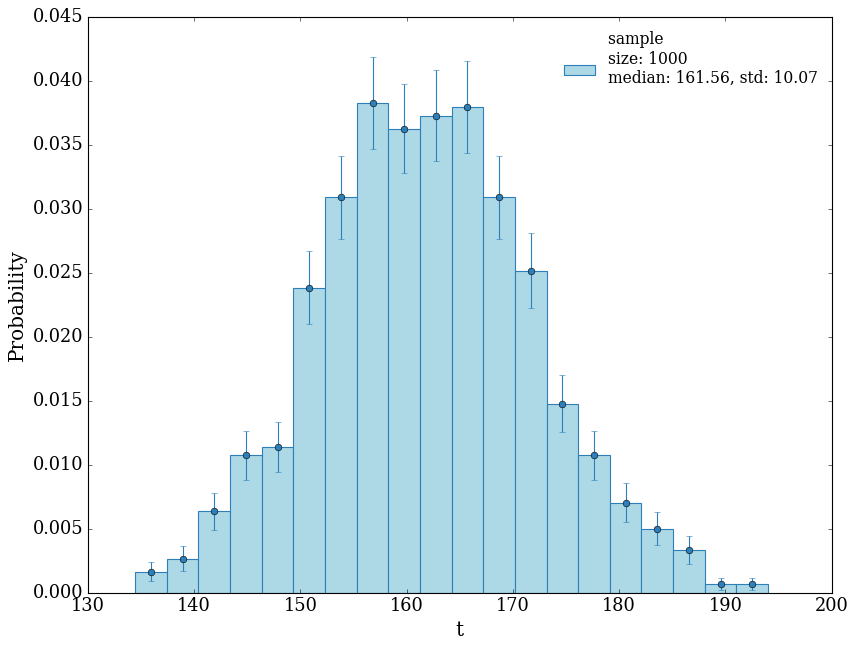

In [9]:
plot_1distribution(tnull, df=-1, xmin=np.min(tnull), xmax=np.max(tnull), nbins=20, 
                   save=False, ymax=None, output_path='', save_name='', label='')

#### signal distribution compared to null

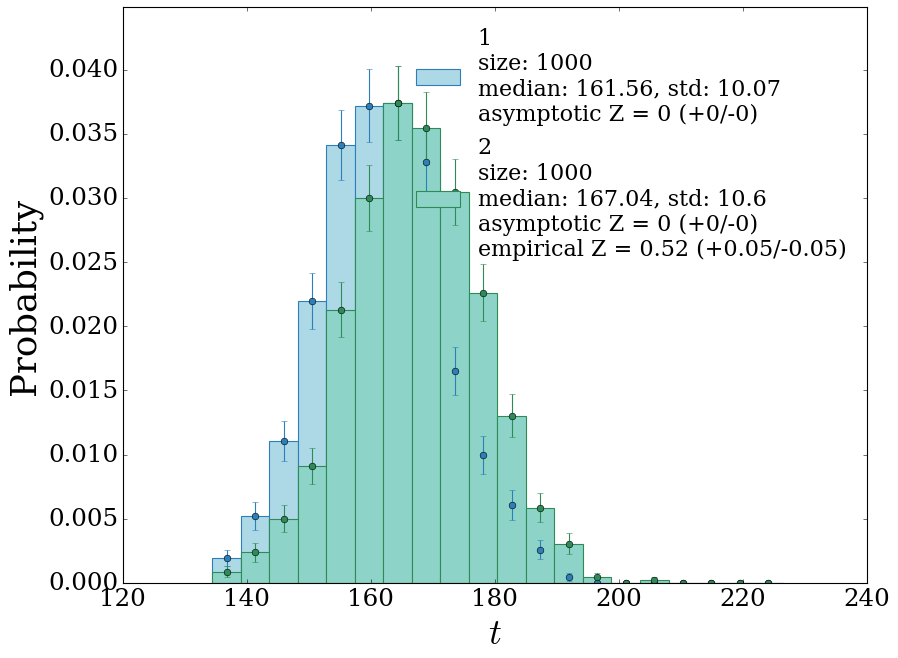

([0, 0, 0], [0.5244005127080407, 0.5748147723849223, 0.4752855949721249])

In [10]:
plot_2distribution(tnull, tobs, df=-1, mu=-1, std=-1, xmin=np.min(tnull), xmax=np.max(tobs)*1.1, ymax=None, xlog=False, nbins=20, 
                   save=False, output_path='', label1='1', label2='2', save_name='', print_Zscore=True)


### recompute the p-values (if tnull has been updated)

In [319]:
for i in range(len(tobs)):
    p = np.sum(tnull>tobs[i])*1./len(tnull)
    pval[i]=p
    if p<0.01: print('window: 'i, 'pval: ', p)

42 pval:  0.0009090909090909091
99 pval:  0.00909090909090909
106 pval:  0.006363636363636364
121 pval:  0.004545454545454545
140 pval:  0.00909090909090909
149 pval:  0.0036363636363636364
155 pval:  0.008181818181818182
171 pval:  0.00909090909090909
206 pval:  0.0036363636363636364
226 pval:  0.0
276 pval:  0.0
349 pval:  0.0027272727272727275
377 pval:  0.0018181818181818182
432 pval:  0.0009090909090909091
464 pval:  0.0009090909090909091
470 pval:  0.0
578 pval:  0.0036363636363636364
737 pval:  0.0036363636363636364
759 pval:  0.006363636363636364
833 pval:  0.0036363636363636364
887 pval:  0.0027272727272727275
902 pval:  0.006363636363636364
927 pval:  0.008181818181818182
951 pval:  0.0027272727272727275


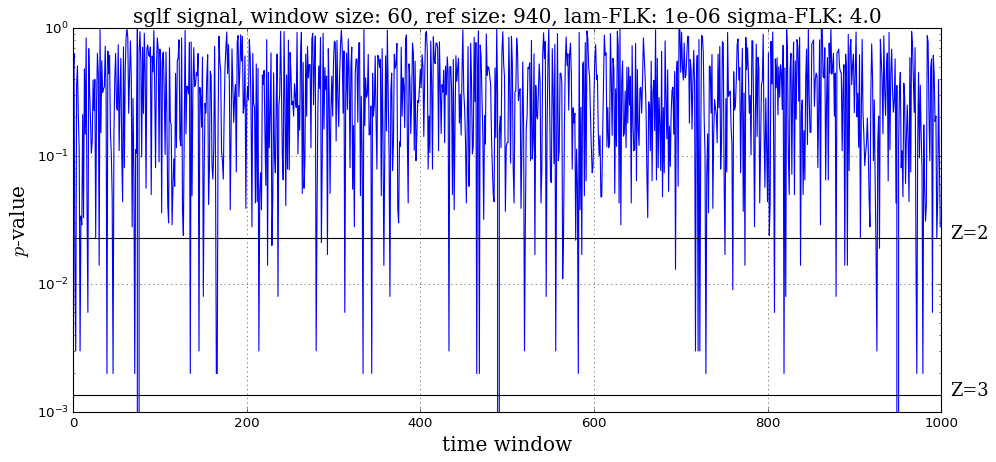

P(Z-score > 2)= 0.061


In [11]:
plot_pvalues(pval, signal, ND, NR, lam, sigma, saveplot=False, savepath='')